# Домашнее задание "Случайные марковские процессы"

### Задание 1

Скачайте текст войны и мир. Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы “Б” и имеющее длину 8-мь символов

In [146]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [166]:
with open('tom_1.txt', 'r', encoding='utf8') as f:
    text = f.read().lower()
    
text = re.sub("[^ЁёА-Яа-я ]", " ", text);
string = re.sub(' +', ' ', text)

In [167]:
print(string)

 лев толстой война и мир том том часть первая часть орая часть третья том лев николаевич толстой война и мир том часть первая е поместья мой верный раб ну что князь генуа и лукка стали не больше как поместьями фамилии бонапарте нет я вас предупреждаю если вы мне не скажете что у нас война если вы еще позволите себе защищать все гадости все ужасы этого антихриста право я верю что он антихрист я вас больше не знаю вы уж не друг мой вы уж не мой верный раб как вы говорите ну здравствуйте здравствуйте я вижу что я вас пугаю садитесь и рассказывайте так говорила в июле года известная анна павловна шерер фрейлина и приближенная императрицы марии феодоровны встречая важного и чиновного князя василия первого приехавшего на ее вечер анна павловна кашляла несколько дней у нее был грипп как она говорила грипп был тогда новое слово употреблявшееся только редкими в записочках разосланных утром с красным лакеем было написано без различия во всех или если вас граф или князь нет в виду ничего лучшего 

Строим матрицу вероятностей

In [168]:
VOC = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(VOC)}

In [169]:
probabilities = np.zeros((len(VOC), len(VOC)))

In [170]:
for cp, cn in zip(string[:-1], string[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [172]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [174]:
df = pd.DataFrame(probabilities, index=(c for c in VOC), columns=(c for c in VOC))

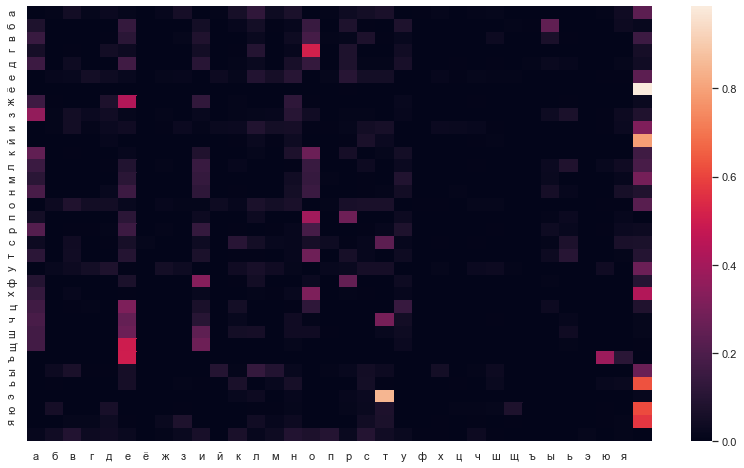

In [175]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

Считаем вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р:

In [179]:
start = POS['п']
end = POS['р']
space = POS[' ']
prior = 1. / len(VOC)

res = 0
for c in list(VOC)[:-1]:
    for d in list(VOC)[:-1]:
        proba = prior * probabilities[start, POS[c]] * probabilities[POS[c], POS[d]] * probabilities[POS[d], end] * probabilities[end, space]
        
        if proba > 0:
            res = res + proba
            
            
print('Вероятность:', res)

Вероятность: 2.8070496753025203e-05


Генерируем слово, начинающееся с буквы “Б” и имеющее длину 8-мь символов

In [263]:
VOC_NOT_SPACE = list(VOC)[:-1]

s = []
start = 'б'
s.append(start)
length = 8

for i in range(length):
    index = POS[s[i]]
    
    # Так как в этом ДЗ мы используем альфавит + пробел, а слово хочется получить без пробелов,
    # то, чтобы не перессчитывать матрицу вероятностей, я расскидываю вероятность получить пробел на остальные буквы
    prob = probabilities[index]
    prob_add = prob[-1] / (len(prob) - 1)
    new_prob = [x + prob_add for x in prob[:-1]]

    next_char = np.random.choice(VOC_NOT_SPACE, p=new_prob)
    s.append(next_char)

print (''.join(s))

бызамецап


### Задание 2

Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM. Попробуйте “построить” (через среднее каждой компоненты) наивный прогноз ряда.

In [264]:
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox

In [265]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Будем использовать ряд monthly-car-sales-in-quebec-1960

In [266]:
car_sales_df = pd.read_csv("Series/monthly-car-sales-in-quebec-1960.csv")

car_sales = car_sales_df.Count

car_sales_df.head()

,Month,Count
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


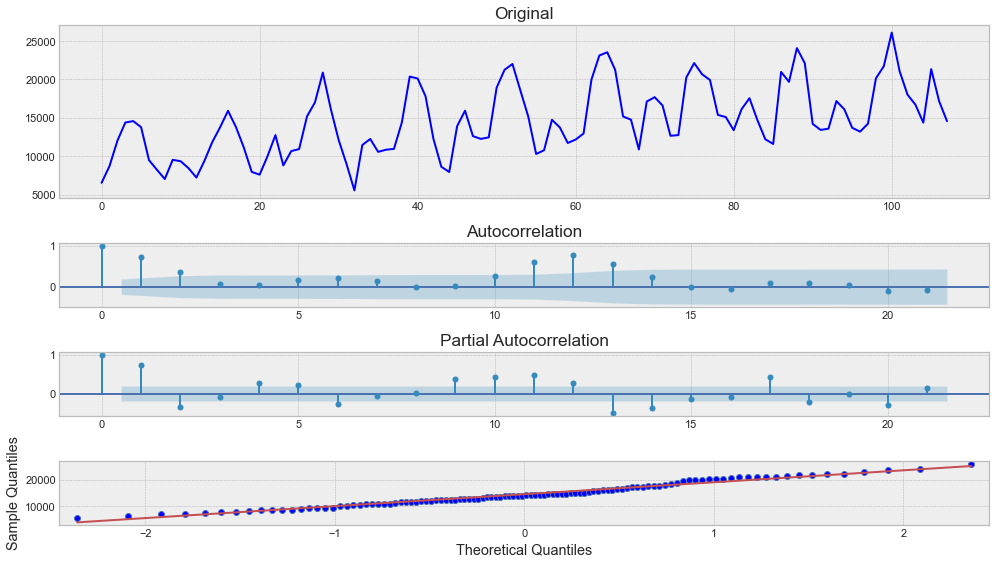

In [267]:
tsplot(car_sales)

Применим преобразование boxcox, а также уберём сезонность и тренд

In [268]:
car_sales = boxcox(car_sales, 0)
car_sales = car_sales[1:] - car_sales[:-1]
car_sales = car_sales[12:] - car_sales[:-12]

Results of Dickey-Fuller Test:
Test Statistic                 -3.516067
p-value                         0.007584
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


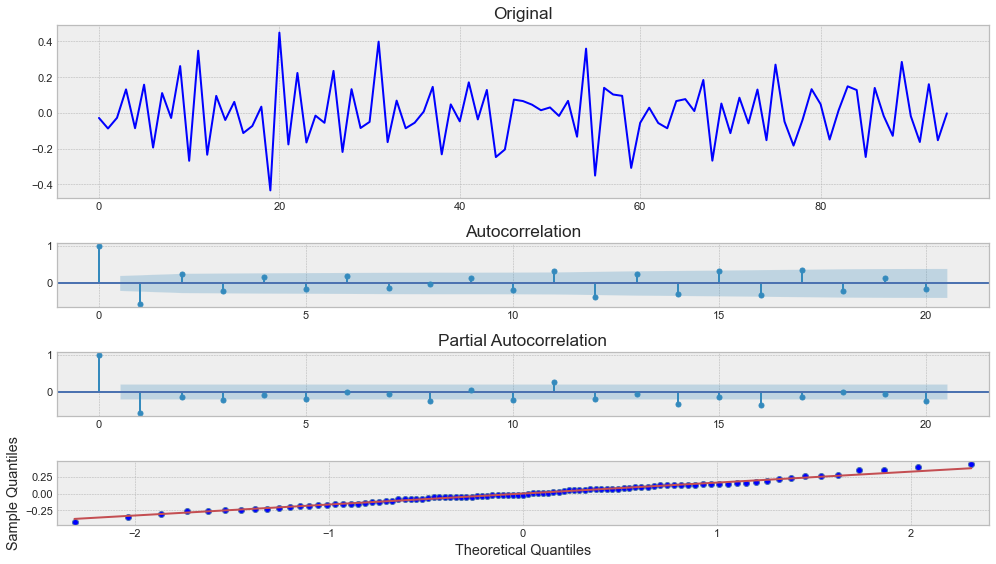

In [269]:
tsplot(car_sales)

Сделаем прогноз с использованием HMM

In [270]:
from hmmlearn.hmm import GaussianHMM

In [271]:
values = car_sales.reshape(-1,1)

Оценим модель с разным количеством компонентов:

In [273]:
for n in range(1, 20):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


1 36.526321230192075
2 49.01687129143029
3 53.32531956270119
4 60.16086246837743
5 62.06921267212682


Fitting a model with 98 free scalar parameters with only 95 data points will result in a degenerate solution.


6 67.54424077461135
7 73.17292228218126
8 73.25036034950524


Fitting a model with 119 free scalar parameters with only 95 data points will result in a degenerate solution.
Fitting a model with 142 free scalar parameters with only 95 data points will result in a degenerate solution.


9 78.78632801052754
10 80.89439131727256


Fitting a model with 167 free scalar parameters with only 95 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 95 data points will result in a degenerate solution.


11 80.18174091315936
12 88.40498953748352


Fitting a model with 223 free scalar parameters with only 95 data points will result in a degenerate solution.
Fitting a model with 254 free scalar parameters with only 95 data points will result in a degenerate solution.


13 84.54252166328313
14 83.54073175813782


Fitting a model with 287 free scalar parameters with only 95 data points will result in a degenerate solution.
Fitting a model with 322 free scalar parameters with only 95 data points will result in a degenerate solution.


15 94.54679787961457
16 93.31400073497055


Fitting a model with 359 free scalar parameters with only 95 data points will result in a degenerate solution.


17 95.67116576352812


Fitting a model with 398 free scalar parameters with only 95 data points will result in a degenerate solution.


18 90.86010000597697
19 93.61605318245478


Построим прогноз ряда (на существующих данных и + 20 новых значений)

Будем использовать n_components=12 (score 88.4)

Fitting a model with 167 free scalar parameters with only 95 data points will result in a degenerate solution.


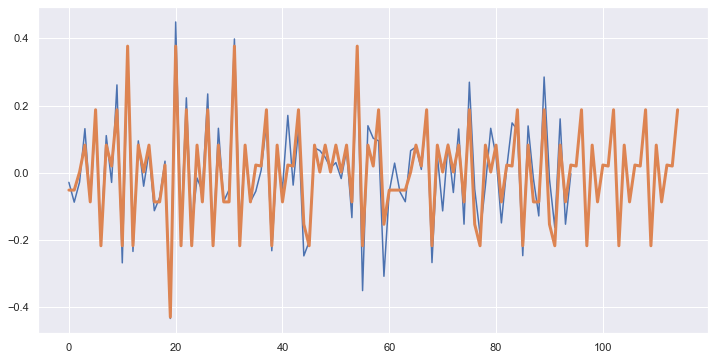

In [274]:
model = GaussianHMM(n_components=12, covariance_type="diag", n_iter=1000)
model.fit(values)

labels = model.predict(values)

# добавляем индексы для 20-ти новых точек
new_labels = list(labels)

for i in range(20):
    prob_next_idx = model.transmat_[new_labels[-1], :].argmax()
    new_labels.append(prob_next_idx)

means = np.zeros((len(values) + 20, 1))

new_labels = np.array(new_labels)

for i in range(model.n_components):
    means[new_labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)